In [1]:
import os, sys
import attr
# add to path
sys.path.append("../..")

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from PIL import Image
seaborn.set()

In [2]:

from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.standard.multinomial import MultinomialResampler

from filterflow.resampling.base import NoResampling


from filterflow.state_space_model import StateSpaceModel

In [3]:
observation_dim = 2
state_dim = 2
T = 150
initial_state          = np.repeat(0., state_dim)
transition_matrix      = np.eye(state_dim) * 0.5
transition_covariance  = np.eye(state_dim) * 0.5

observation_matrix     = np.eye(observation_dim) *0.5
observation_covariance = np.eye(observation_dim)*0.1

In [4]:
tf_observation_matrix = tf.constant(observation_matrix, dtype = tf.float32)
tf_observation_covariance = tf.constant(observation_covariance, dtype = tf.float32)


tf_transition_matrix = tf.constant(transition_matrix, dtype = tf.float32)
tf_transition_covariance =  tf.constant(transition_covariance, dtype = tf.float32)

In [5]:
# Transition
state_dim = tf_transition_covariance.shape.as_list()[0]
transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                                    tf_transition_covariance)

transition_model = RandomWalkModel(tf_transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                             tf_observation_covariance)
observation_model = LinearObservationSampler(tf_observation_matrix, observation_error)

In [6]:
## State space model
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
initial_particle = tf.constant(np.random.random(state_dim), dtype = tf.float32)
states, observations = ss_model(initial_particle, T)

In [7]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

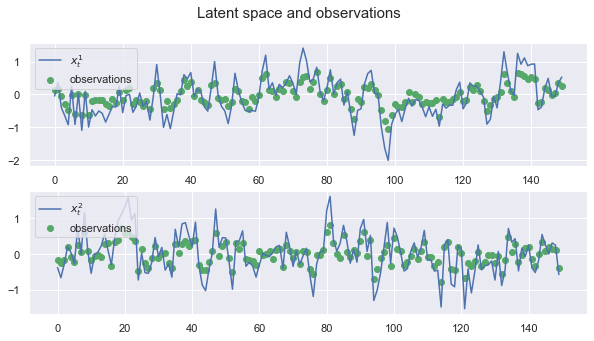

In [8]:
linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [41]:
# store observations
batch_size = 1
n_particles = 1000
dimension = 2

resampling_criterion = NeffCriterion(0.5, is_relative=True)
resampling_method = SystematicResampler()

weights = tf.ones((batch_size, n_particles), dtype=float)/tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
initial_state = State(particles=initial_particles, log_weights= tf.math.log(weights), weights=weights, log_likelihoods=log_likelihoods)



In [42]:
observations_list = observations[:1]

In [43]:
obs_data = tf.data.Dataset.from_tensor_slices(observations_list)

In [69]:
init_g_matrix = 0.1 * np.eye(2)
init_g_cov = 0.5 * np.eye(2)

init_f_matrix = np.eye(2)
init_f_cov = 0.5 * np.eye(2)

g_matrix = tf.constant(init_g_matrix, dtype = tf.float32)
g_covariance = tf.constant(init_g_cov, dtype = tf.float32)


f_matrix = tf.Variable(init_f_matrix, dtype = tf.float32, trainable=True)
f_covariance =  tf.constant(init_f_cov, dtype = tf.float32)

# Create an optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.01)


# transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), 
#                                                                 f_covariance)
# transition_model = RandomWalkModel(f_matrix, transition_noise)

# # Observation
# observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), 
#                                                          g_covariance)
# observation_model = LinearObservationSampler(g_matrix, observation_error)

# # proposal
# proposal_model = BootstrapProposalModel(transition_model)

# # particle filter
# particle_filter = SMC(observation_model, transition_model, 
#                                           proposal_model, resampling_criterion, resampling_method)
        
        

In [70]:
def make_filter(f_matrix, f_covariance, g_matrix, g_covariance):
    transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), f_covariance)
    transition_model = RandomWalkModel(f_matrix, transition_noise)

    observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), g_covariance)
    observation_model = LinearObservationSampler(g_matrix, observation_error)
    # proposal
    proposal_model = BootstrapProposalModel(transition_model)

    return SMC(observation_model, transition_model, proposal_model, resampling_criterion, resampling_method)

In [71]:
smc = make_filter(f_matrix, f_covariance, g_matrix, g_covariance)

In [72]:
observation_series = tf.data.Dataset.from_tensor_slices(observations_list)

In [73]:
@tf.function
def loss_func():
    final_state = smc(initial_state, observation_series=observation_series, n_observations=len(observations_list), return_final = True)
    return -final_state.log_likelihoods / T

In [76]:
@tf.function
def train_one_step(optimizer):
    var_list= [f_matrix]
    with tf.GradientTape() as tape:
        tape.watch(var_list)
        loss = loss_func()
    grads = tape.gradient(loss, var_list)
    optimizer.apply_gradients(zip(grads,var_list))

    return loss, grads

@tf.function
def train(optimizer, num_steps = 100):
    for step in tf.range(num_steps):
        loss, grads = train_one_step(optimizer)
        if step % 100 == 0:
            tf.print('Step', step, ': loss', loss)
            tf.print('f_matrix', f_matrix)
            tf.print('')
    return f_matrix, f_covariance, g_matrix, g_covariance
            

In [77]:
train(optimizer, num_steps=1000)

Step 0 : loss [0.00366725936]
f_matrix [[0.229698941 0.116312273]
 [-0.0623004399 0.171401769]]

Step 100 : loss [0.00366505305]
f_matrix [[0.0314031132 0.172332719]
 [-0.0221955776 -0.163844973]]

Step 200 : loss [0.00366832735]
f_matrix [[0.0248852074 0.182360724]
 [-0.0156616569 -0.228842229]]

Step 300 : loss [0.00365597731]
f_matrix [[0.0149693945 0.188602448]
 [-0.0345134251 -0.232034102]]

Step 400 : loss [0.00365661317]
f_matrix [[0.018153239 0.188512817]
 [-0.0145059871 -0.228921443]]

Step 500 : loss [0.00366086024]
f_matrix [[0.0259975474 0.172853529]
 [-0.0427784361 -0.239013553]]

Step 600 : loss [0.003660555]
f_matrix [[0.0164350588 0.189218149]
 [-0.0150220934 -0.242411837]]

Step 700 : loss [0.00366358762]
f_matrix [[0.0230324753 0.177214012]
 [-0.0262944698 -0.230700701]]

Step 800 : loss [0.00365238194]
f_matrix [[0.018390948 0.178106144]
 [-0.0248826146 -0.236538917]]

Step 900 : loss [0.00366535503]
f_matrix [[0.0113535579 0.186908796]
 [-0.0298120938 -0.239582583]]

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.02267515,  0.18126059],
        [-0.01080146, -0.24423888]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5, 0. ],
        [0. , 0.5]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.1, 0. ],
        [0. , 0.1]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5, 0. ],
        [0. , 0.5]], dtype=float32)>)